# PhaseNet网络模型构建简析

## 一.Unet模型---一个优秀的语义分割模型
* 第一部分是主干特征提取部分，我们可以利用主干部分获得一个又一个的特征层，Unet的主干特征提取部分与VGG相似，为卷积和最大池化的堆叠。利用主干特征提取部分我们可以获得五个初步有效特征层，在第二步中，我们会利用这五个有效特征层可以进行特征融合.<br>
* 第二部分是加强特征提取部分，我们可以利用主干部分获取到的五个初步有效特征层进行上采样，并且进行特征融合，获得一个最终的，融合了所有特征的有效特征层。<br>
* 第三部分是预测部分，我们会利用最终获得的最后一个有效特征层对每一个特征点进行分类，相当于对每一个像素点进行分类。<br>

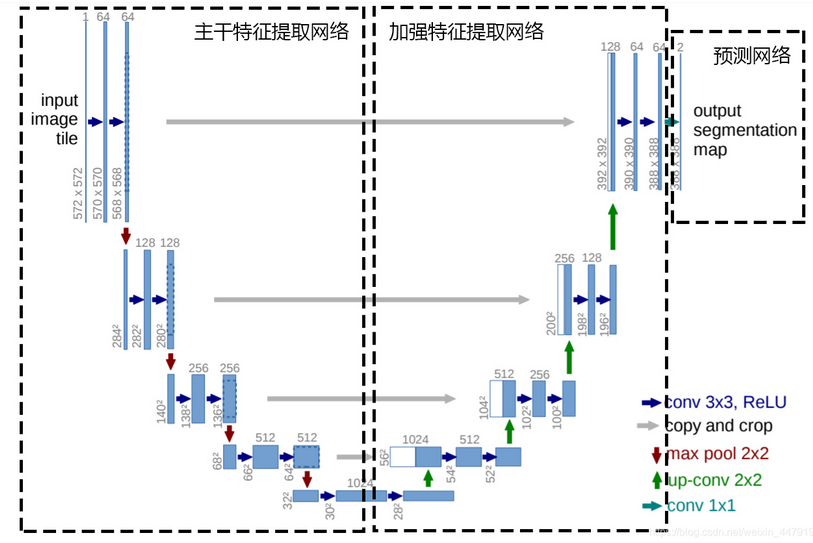

### 1.概念理解：
#### (1)通道channel:
*假设现有一个为 6×6×3 的图片样本，使用 3×3×3的卷积核（filter）进行卷积操作。此时输入图片的 channels 为 3 ，而卷积核中的 in_channels 与 需要进行卷积操作的数据的 channels 一致（这里就是图片样本，为3）。<br>
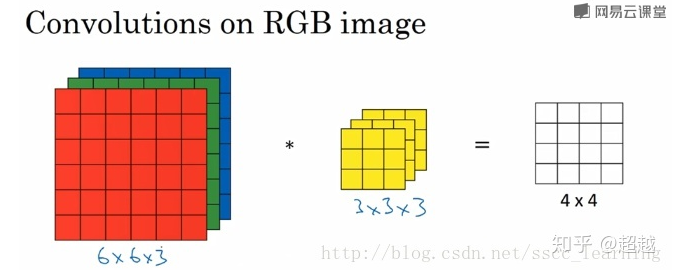
接下来，进行卷积操作，卷积核中的27个数字与分别与样本对应相乘后，再进行求和，得到第一个结果。依次进行，最终得到4×4的结果。<br>
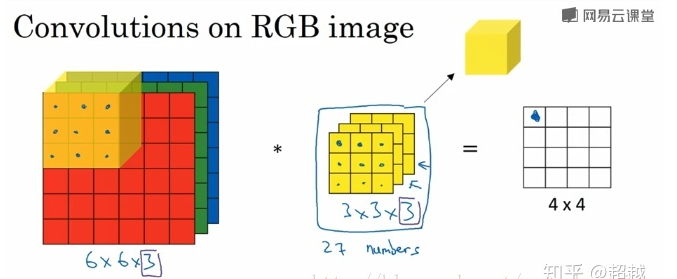
上面步骤完成后，由于只有一个卷积核，所以最终得到的结果为4×4×1，out_channels为1。<br>
在实际应用中，都会使用多个卷积核。这里如果再加一个卷积核，就会得到4×4×2的结果。<br>
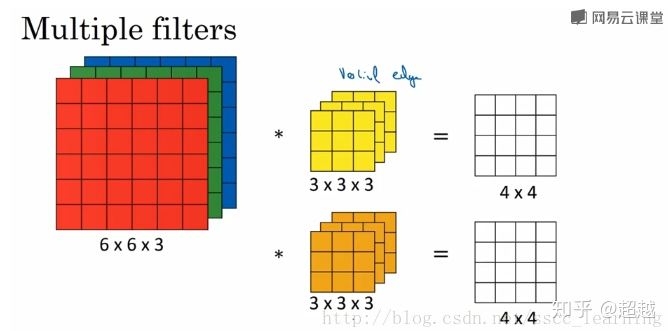
tensorflow中channel的体现
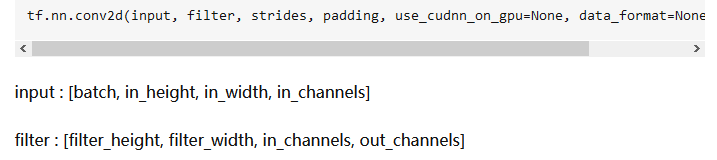
链接：https://link.zhihu.com/?target=https%3A//blog.csdn.net/sscc_learning/article/details/79814146

#### （2）skip connection<br>
* 跳跃连接，通常用于残差网络中。它的作用是：在比较深的网络中，解决在训练的过程中梯度爆炸和梯度消失问题。<br><br>
  U-Net是一种典型的编码-解码结构，编码器部分利用池化层进行逐级下采样，解码器部分利用反卷积进行逐级上采样，原始输入图像中的空间信息与图像中的边缘信息会被逐渐恢复，由此，低分辨率的特征图最终会被映射为像素级的分割结果图。而为了进一步弥补编码阶段下采样丢失的信息，在网络的编码器与解码器之间，U-Net算法利用Concat拼接层来融合两个过程中对应位置上的特征图，使得解码器在进行上采样时能够获取到更多的高分辨率信息，进而更完善地恢复原始图像中的细节信息，提高分割精度。<br><br>

  而增加了skip connection结构的U-Net，能够使得网络在每一级的上采样过程中，将编码器对应位置的特征图在通道上进行融合。通过底层特征与高层特征的融合，网络能够保留更多高层特征图蕴含的高分辨率细节信息，从而提高了图像分割精度。<br>
  

#### （3）卷积算法
* 卷积核：用不同的滤波器对图像进行卷积，可以通过应用滤波器进行边缘检测、模糊和锐化等操作。不同类型的过滤器(卷积核)后的各种卷积图像处理提取不同的特征。<br>
* 步长（stride）：决定滑动多少步可以到边缘 ；<br>
* 填充（padding）:填充值zero-padding：在外围边缘补充若干圈0，方便从初始位置以步长为单位可以刚好滑倒末尾位置，通俗地讲就是为了总长能被步长整除。<br>
* 特征图（Feature Map）：卷积核卷出来的，而不同的特征提取（核）会提取不同的feature.<br>

#### （4）strided convolution
* Strided Convolution其实就是在过滤器移动过程中进行跳格计算，stride具备跳格能力，避免重复计算。
  stride也会影响feature map的规模，例如stride=2时大概会使feature map规模缩小为1/2的大小。<br>


#### （5）步长卷积计算公式
* 正向卷积：
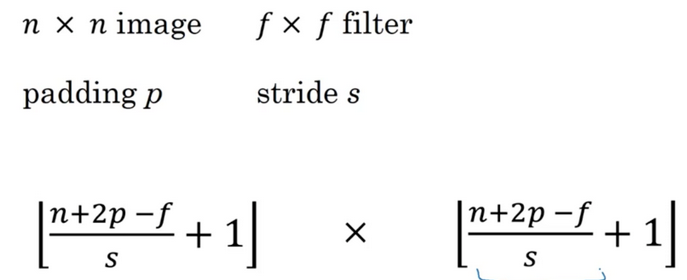
* 反卷积：
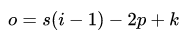
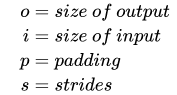

#### （6）TensorFlow中padding卷积的两种方式“SAME”和“VALID”
* padding = “SAME”输入和输出大小关系如下：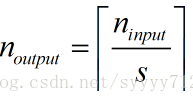
  输出大小等于输入大小除以步长向上取整，s是步长大小；
* padding = “VILID”输入和输出大小关系如下：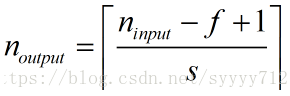
  输出大小等于输入大小减去滤波器大小加上1，最后再除以步长（f为滤波器的大小，s是步长大小）。
* 卷积核大小，滑动步长直接影响最后的卷积结果的大小，且padding为SAME模式时，先对原图像进行填充，再做卷积，填充值须根据卷积核大小及滑动步长决定；而padding为VALID模式时，很简单粗暴直接从原始图像的首段开始卷积，到最后不能匹配卷积核的部分直接舍去。

#### （7）Relu激活函数
tf.nn.relu(features, name=None)
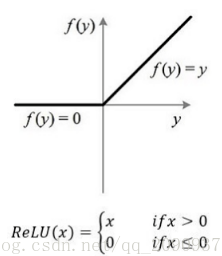

### 2.卷积核
https://blog.csdn.net/chaipp0607/article/details/72236892
* 平滑均值滤波：选择卷积核，该卷积核的作用在于取九个值的平均值代替中间像素值，所以起到的平滑的效果。
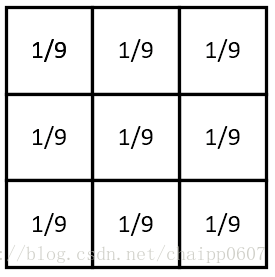
* 高斯平滑：高斯平滑水平和垂直方向呈现高斯分布，更突出了中心点在像素平滑后的权重，相比于均值滤波而言，有着更好的平滑效果。
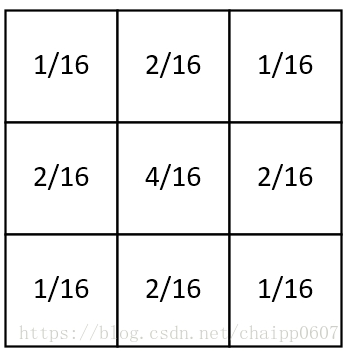
* 图像锐化：该卷积利用的其实是图像中的边缘信息有着比周围像素更高的对比度，而经过卷积之后进一步增强了这种对比度，从而使图像显得棱角分明、画面清晰，起到锐化图像的效果。
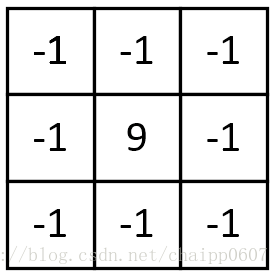
* 梯度Prewitt：
  水平梯度卷积核：
  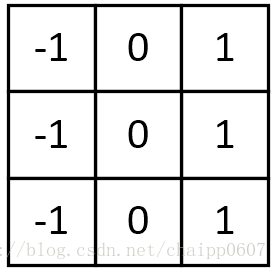
  垂直梯度卷积核：
  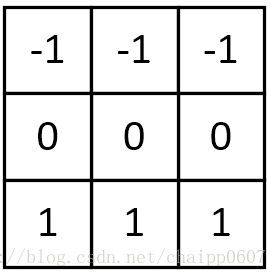
* Soble边缘检测：更强调了和边缘相邻的像素点对边缘的影响。
  水平梯度卷积核：
  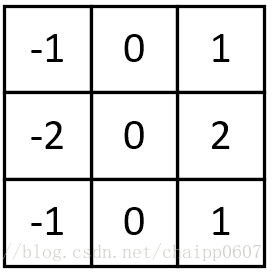
  垂直梯度卷积核：
  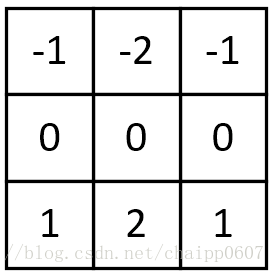

## 二.PhaseNet卷积计算

### 1.计算理解
* Unet主要可分为三部分来看分别为左（特征提取）、中（copy and crop）、右（上采样）。
**（1）左：特征提取部分：它是一个收缩网络，通过四个下采样，使图片尺寸减小，在这不断下采样的过程中，特征提取到的是浅层信息。**
**（2）中（copy and crop）：在UNet有四个拼接操作。Skip connect,这一操作的目的是为了融合特征信息，使深层和浅层的信息融合起来，在拼接的时候要注意，不仅图片大小要一致（故要crop,是为了使图片大小一致）而且特征的维度（channels）也要才一样，才可以拼接。**
**（3）右（上采样部分 up-conv）也叫扩张网络，图片尺寸变大，提取的是深层信息，使用了四个上采样，在上采样的过程中，图片的通道数是减半的，与左部分的特征提取通道数的变化相反。在上采样的过程融合了左边的浅层的信息即拼接了左边的特征。**

padding=‘SAME’:故通道长度分别为：（左侧数据为每层的通道数）
  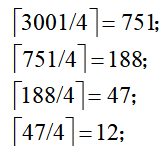

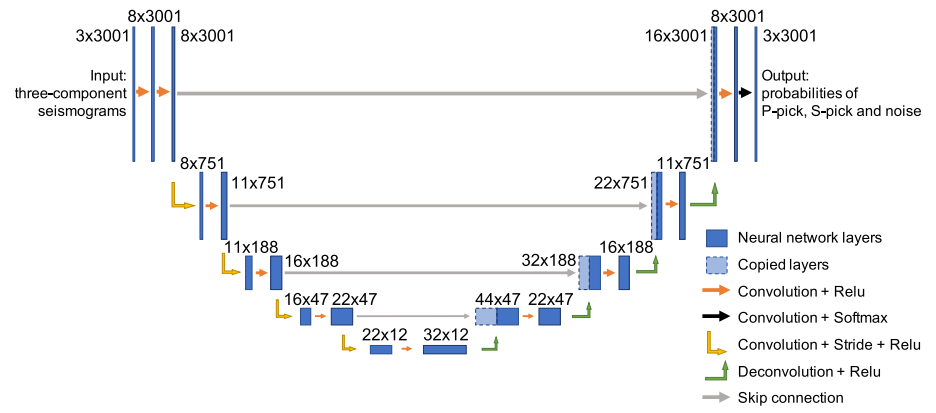